# Part 1

# 1.1  Data Cleaning Procedures 

1. A copy of the original training dataset was made to preserve the raw data.

2. Missing values were checked using isnull().sum() and any rows with missing values in the 'Text' or 'Category' columns were removed using dropna().

3. Duplicate text entries were removed by checking for repeated rows based on the 'Text' column using drop_duplicates().

4. A new feature ‘Word_count’ was created by computing the number of words in each article. This gives a basic understanding of the length of each document and supports visualization and downstream analysis.

5. An additional feature ‘Log_Word_count’ was added using a log(1 + word count) transformation to normalize the distribution and reduce skewness for boxplot visualization.

In [235]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

train_data = pd.read_csv("data/BBC News Train.csv")
test_data = pd.read_csv("data/BBC News Test.csv")
full_data = pd.concat([train_data,test_data], ignore_index=True)

print (train_data.shape)
print (test_data.shape)
print (full_data.shape)

df_train = train_data.copy()

#Checking for missing values or duplicates, if so drop it
print(df_train.isnull().sum())
df_train.dropna(subset=['Text', 'Category'], inplace=True)
df_train.drop_duplicates(subset=['Text'], inplace=True)

df_train['Word_count'] = df_train['Text'].apply(lambda x: len(str(x).split()))
df_train['Log_Word_count'] = np.log1p(df_train['Word_count'])



(1490, 3)
(735, 2)
(2225, 3)
ArticleId    0
Text         0
Category     0
dtype: int64


# 1.2 General Exploratory Data Analysis (EDA)

#### Data Checking and Basic Visualisation

1. General dataframe shape, sample size and features understanding with df.info()

2.  Bar Plot of Category Distribution
This intends to check if there are any obvious imbalanced features in the whole dataset. For ideal case, we can balance down-sample sports and business by a factor.

3. Histogram of Word Count (Text Length)
Distribution of word count for each article shown as histogrm. There are some potentially outliners with extreme high word count identified in the process.

4. Boxplot of Log (Word Count) by Category
This will further confirm the finding in point 3 above. The outliners should be removed.

   ArticleId                                               Text  Category  \
0       1833  worldcom ex-boss launches defence lawyers defe...  business   
1        154  german business confidence slides german busin...  business   
2       1101  bbc poll indicates economic gloom citizens in ...  business   
3       1976  lifestyle  governs mobile choice  faster  bett...      tech   
4        917  enron bosses in $168m payout eighteen former e...  business   

   Word_count  Log_Word_count  
0         301        5.710427  
1         325        5.786897  
2         514        6.244167  
3         634        6.453625  
4         355        5.874931  
<class 'pandas.core.frame.DataFrame'>
Index: 1440 entries, 0 to 1489
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ArticleId       1440 non-null   int64  
 1   Text            1440 non-null   object 
 2   Category        1440 non-null   object 
 3   Word_count    

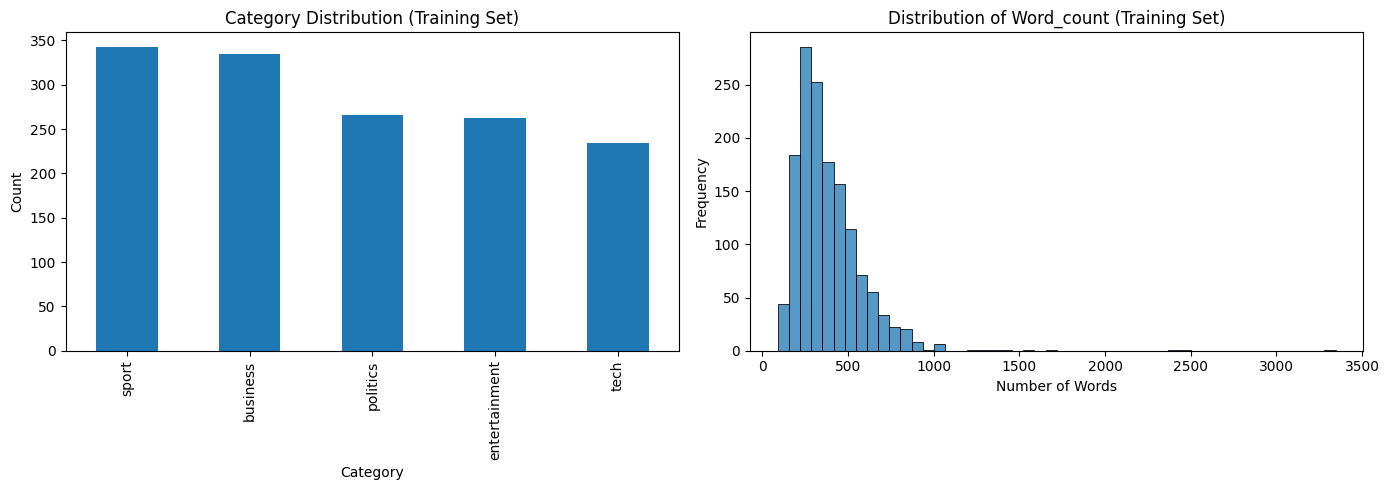

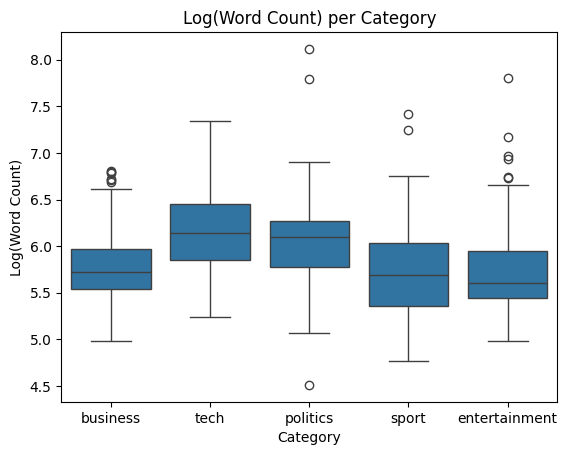

In [236]:
#Checking the structure of the data
print(df_train.head(5))
print(df_train.info())
print (df_train.shape)

# Set up subplot layout
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
plt.subplots_adjust(hspace=0.5,wspace=0.5)

# Distribution of Category
df_train['Category'].value_counts().plot(kind='bar', ax=axes[0])
axes[0].set(title='Category Distribution (Training Set)', xlabel='Category', ylabel='Count')

# Distribution of Total word count in the text 
sns.histplot(df_train['Word_count'], bins=50, ax=axes[1])
axes[1].set(title='Distribution of Word_count (Training Set)', xlabel='Number of Words', ylabel='Frequency')
plt.tight_layout()
plt.show()

# Boxplot of Word count per Category
sns.boxplot(data=df_train, x='Category', y='Log_Word_count')
plt.title("Log(Word Count) per Category")
plt.xlabel("Category")
plt.ylabel("Log(Word Count)")
plt.show()


#### Data Cleaning for outliners

Remove the outliners identified in the boxplot above. Rows that satisfy the range idntified below will be kept, and the other rows will be dropped.

In [237]:
def manual_outlier_removal(df):
    conditions = (
        ((df['Category'] == 'business') & (df['Log_Word_count'].between(5.0, 6.6))) |
        ((df['Category'] == 'politics') & (df['Log_Word_count'].between(5.1, 6.9))) |
        ((df['Category'] == 'sport') & (df['Log_Word_count'].between(5.0, 6.7))) |
        ((df['Category'] == 'entertainment') & (df['Log_Word_count'].between(5.0, 6.6)))
    )
    return df[conditions]

df_train_cleaned = manual_outlier_removal(df_train)

#### Analysis Plan

- Text Vectorization

All text data (both train and test data) will be vectorized into a fixed-length numerical representation using the same vectorization method (sklearn's TfidfVectorizer in this case). 

This step will be applied to both training and test data simultaneously to ensure consistent feature space.

- Matrix Factorization

The high-dimensional vectorized data will be reduced into a lower-dimensional latent space using matrix factorization techniques (such as NMF or SVD using sklean or numpy linear algirthm). 

This will be done separately on the training and test sets, using a shared model structure to maintain feature alignment.

- Unsupervised Clustering

After dimensionality reduction, an unsupervised KNN-based model will be used to group similar texts into clusters. This will be done without using the known labels.

- Evaluation using True Labels

The output clusters from the unsupervised model will be compared against the true labels available in the training data. Label permutation and alignment will be used to calculate clustering accuracy such that the best match of numerial label and string label can be matched.


# 1.3 Text Vectorization

#### My understanding on Word Embeddings & NLP

Word embeddings is a tehnique to store the meaning of "any word" (more precisely "tokens" ) based on some previous statistical training. The word embeddings for one word/token is represented as a 1D high dimensional array which can have thousands of dimensions depending on the statistical library that the tokens (or words) are pre-trained on.

For each dimension in a token/word, it is represting the count in a single document. The rows are the words/tokens and the columns are the different documents behind the scene. The value at the intersection of the table is the count of the token/word in that document. When we have thousands of document, basically we are doing a huge statistical exercise on the frequency of appearance of the token/word of each document. Therefore, as the documents are well defined, we can then use this statistical table to group similiar words/tokens together by using a 1D high dimensional array which can represent "meaning".

To dig deeper, token is being the basic unit instead of words. The tokenization is being taken place before doing the document-word counting. It is a token - token matrix which will grow dynamically to find new merged tokens. Eventually, these tokens will form the basic units of counting for the token-document table.

---

#### Applying vectorization using TfidfVectorizer

- Training set and test set are transformed together first
- Then they are splitted again for the next step on matrix factorization

In [238]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()

# The full dataset (train + test) is used to fit the vectorizer
full_tran_M = vectorizer.fit_transform(full_data['Text']).toarray()
print (f'full_data transformed_full_text_matrix.shape: {full_tran_M.shape}')

# # Split the full transformed matrix back to train,validation and test set
train_tran_M = full_tran_M[:train_data.shape[0],]
test_tran_M = full_tran_M[full_tran_M.shape[0]-test_data.shape[0]:,]

print (f'train_tran_M.shape: {train_tran_M.shape}')
print (f'test_tran_M.shape: {test_tran_M.shape}')


full_data transformed_full_text_matrix.shape: (2225, 29421)
train_tran_M.shape: (1490, 29421)
test_tran_M.shape: (735, 29421)


# 1.4 Matrix Factorization

The Train set and Test Set should not be separated during factorization.

The reason for thet because the same consistent feature space should be maintained. 
If only the train set is factorized, the latent space is based on only part of the data which could cause generalization problem when testing.

---
#### Steps

- Both SVD model from sklearn and NMF model have been tested. 

- TruncatedSVD is a much faster algorithm and it will good for the iterative search of hyperparameters later on. NMF is thus not being used in this case.

- The split of train and test data happens after factorization.


In [239]:
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF

def matrix_factorization(A, _latent_dim=2, type='SVD', _model=None, _random_state = 0):
    if type == 'SVD':
        if _model is None:
            tsvd = TruncatedSVD(n_components=_latent_dim, random_state = _random_state).fit(A)
        else:
            tsvd = _model
        X = tsvd.transform(A)
        return X, tsvd
    
    # elif type == 'NMF':
    #     if _model is None:
    #         NMF_model = NMF(n_components=_latent_dim, init='random', random_state=0, solver='cd', beta_loss='frobenius', max_iter=200)
    #         W = NMF_model.fit_transform(A)
    #     else:
    #         W = _model.transform(A)
    #         NMF_model = _model
    #     return W, NMF_model
    
    else:
        return None, None

# Factorize the train and test text matrix separately
latent_dim = 50
full_fac_M,fac_model = matrix_factorization(full_tran_M, _latent_dim=latent_dim)

train_fac_M = full_fac_M[:train_data.shape[0],:]
test_fac_M = full_fac_M[full_tran_M.shape[0]-test_data.shape[0]:,]

print (train_fac_M.shape)
print (test_fac_M.shape)


(1490, 50)
(735, 50)


# 1.5 Unsupervised Clustering Model Training

Unsupervised model KMeans method is being used in the first trial model. As it is known that the number of total categories = 5 for all articles, this n = 5 is used in KMeans clustering. The True label is not involved in the unsupervised trainig, but it is being used for label mapping - such that the clusters will be assigned with the categorial string that scores the highest accuracy.

The accuracy together with the confsuion matrix are being used to check how accurate the first model is.

In [240]:
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import itertools

# Function to find the best permutation of clustering labels to match true labels
def label_permute_compare(ytdf,yp,_n=5):
    """
    ytdf: labels dataframe object
    yp: clustering label prediction output
    Returns permuted label order and accuracy. 
    Example output: (3, 4, 1, 2, 0), 0.74 
    """
    label_encoder = LabelEncoder()
    ytrue = label_encoder.fit_transform(ytdf.values.flatten())
    
    best_perm = ()
    best_acc = 0.0
    
    for perm in itertools.permutations(range(_n)): 
        y_pred = np.array([perm[label] for label in yp])
        acc = accuracy_score(ytrue, y_pred)
        if acc > best_acc:
            best_acc = acc
            best_perm = perm
            
    return best_perm, best_acc

n = 5
train_label = train_data['Category']
model = KMeans(n_clusters = n, random_state=0)
model.fit(train_fac_M)

# Get the best label permutation and accuracy
labelorder, acc = label_permute_compare(train_label, model.labels_)
print ('Accuracy of preliminary baseline model:', acc)
predicted_labels = np.array([labelorder[label] for label in model.labels_])

# Create a mapping from numeric labels to original string labels (Use on both train and test)
label_map = dict(zip(range(n), np.unique(train_label.values.flatten())))

# Convert numeric labels back to original string labels
predicted_str = np.array([label_map[i] for i in predicted_labels])
true_str = train_label.values.flatten()

# Confusion Matrix
train_cm = confusion_matrix(true_str, predicted_str, labels=np.unique(true_str))

print (f'Confusion matrix for baseline model on training data {train_cm}')

# Predict the cluster labels for the test set
test_cluster_labels = model.predict(test_fac_M)
test_predicted_str = np.array([label_map[i] for i in test_cluster_labels])
print (test_predicted_str)


Accuracy of preliminary baseline model: 0.6100671140939598
Confusion matrix for baseline model on training data [[322   0   1  13   0]
 [  6  82   0 143  42]
 [ 28   0 169  77   0]
 [  1  10   0 335   0]
 [ 15   1   0 244   1]]
['business' 'business' 'business' 'entertainment' 'business' 'business'
 'tech' 'business' 'sport' 'entertainment' 'entertainment' 'business'
 'tech' 'business' 'politics' 'business' 'tech' 'business' 'sport'
 'business' 'entertainment' 'tech' 'business' 'entertainment'
 'entertainment' 'business' 'entertainment' 'business' 'business'
 'entertainment' 'tech' 'business' 'entertainment' 'entertainment'
 'business' 'business' 'business' 'entertainment' 'sport' 'entertainment'
 'business' 'business' 'business' 'business' 'business' 'business'
 'business' 'entertainment' 'tech' 'entertainment' 'business'
 'entertainment' 'entertainment' 'entertainment' 'business' 'tech'
 'business' 'business' 'business' 'business' 'business' 'business'
 'business' 'tech' 'entertainme

# 1.6 Improving Model Performance (Hyperparameters Tuning)

While creating iterative loops to search for hyperparameters, the following are considered in each iteration:

1. Latent dimension of factorization

How much the dimension is reduced is one of the factors that will affect the model accuracy, so it is being used in the search. However, higher order of this dimension will need more computing time and effort.

2. Choise of Unsupervised Model

Two models will be searched in the loop - sklean.cluster.KMeans & sklean.cluster.AgglomerativeClustering

3. Linkages & Metrics

For AgglomerativeClustering, there are variations in Linkages & Metrics. These variations also be in the search.

In [241]:
import warnings

# Function to run agglomerative clustering with various hyperparameters
def run_agglomerative_clustering_iter(X_fac, y_label, n_clusters, dim, linkages, metrics):
    for linkage in linkages:
        for metric in metrics:
            if linkage == 'ward' and metric != 'euclidean':
                continue
            try:
                model = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage, metric=metric)
                model.fit(X_fac)
                labelorder, acc = label_permute_compare(y_label, model.labels_, _n=n_clusters)
                results.append({
                    'model': 'Agglomerative',
                    'latent_dim': dim,
                    'linkage': linkage,
                    'metric': metric,
                    'accuracy': acc
                })
            except Exception as e:
                warnings.warn(f'Skipped dim={dim}, linkage={linkage}, metric={metric} due to error: {str(e)}')

# Function to run KMeans clustering with various hyperparameters
def run_kmeans_clustering_iter(X_fac, y_label, n_clusters, dim):
    try:
        kmeans = KMeans(n_clusters=n_clusters, random_state=0)
        kmeans.fit(X_fac)
        labelorder, acc = label_permute_compare(y_label, kmeans.labels_, _n=n_clusters)
        results.append({
            'model': 'KMeans',
            'latent_dim': dim,
            'linkage': None,
            'metric': None,
            'accuracy': acc
        })
    except Exception as e:
        warnings.warn(f'KMeans failed at dim={dim} due to error: {str(e)}')

# Prepare Hyperparameter tuning for clustering models
latent_dims = [2,3,4] + list(range(5, 200, 5))
linkages = ['ward', 'complete', 'average', 'single']
metrics = ['euclidean', 'l1', 'l2', 'manhattan', 'cosine']

n_clusters = 5
y_label = train_data['Category']
results = []

for dim in latent_dims:
    
    # Full dataset factorization first, then split to get train factorized matrix
    full_fac, _ = matrix_factorization(full_tran_M, _latent_dim=dim)
    X_fac = full_fac[:train_data.shape[0],:]
    
    # Agglomerative variations
    run_agglomerative_clustering_iter(X_fac, y_label, n_clusters, dim, linkages, metrics)
    
    # KMeans variation
    run_kmeans_clustering_iter(X_fac, y_label, n_clusters, dim)

best_result = max(results, key=lambda x: x['accuracy'])

print("\n Best Configuration:")
print(f"model       = {best_result['model']}")
print(f"latent_dim  = {best_result['latent_dim']}")
print(f"linkage     = {best_result['linkage']}")
print(f"metric      = {best_result['metric']}")
print(f"accuracy    = {best_result['accuracy']:.4f}")


 Best Configuration:
model       = KMeans
latent_dim  = 5
linkage     = None
metric      = None
accuracy    = 0.8517


# 1.7 Plotting Accuracy against Latent Dimension Search 

Matrix Factorization being one of the major step, it is essential to check its influences on the accuracy of the model. From the plot, higher latent dimension does not necessary give us a more accurate model which is a good news as we also save some computing power while getting a better model.

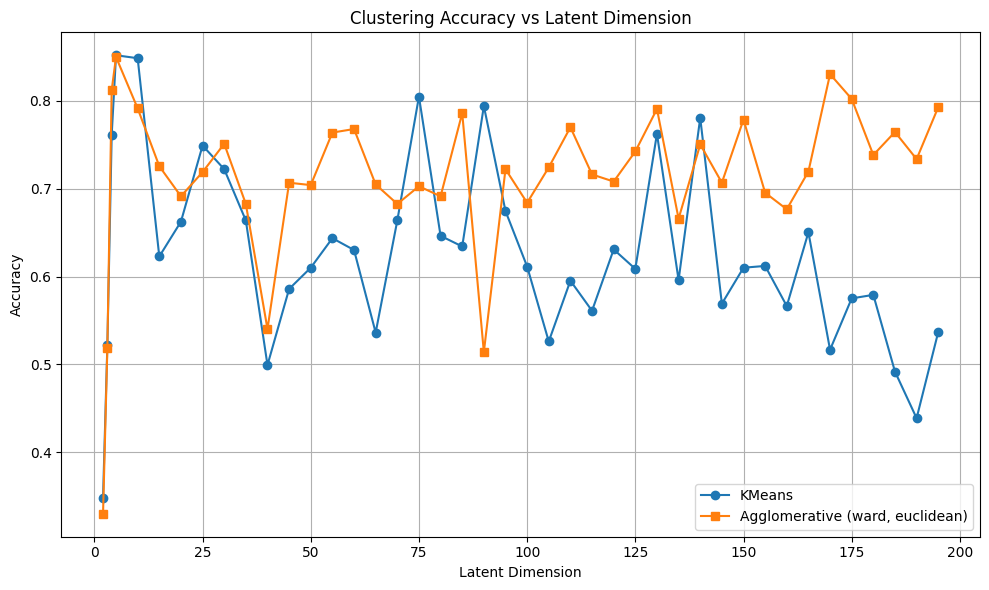

In [242]:
import matplotlib.pyplot as plt

dims = sorted(set([r['latent_dim'] for r in results]))

kmeans_acc = []
agglo_acc = []

for dim in dims:
    kmeans_result = next((r for r in results if r['model'] == 'KMeans' and r['latent_dim'] == dim), None)
    agglo_result = next((r for r in results if r['model'] == 'Agglomerative' and r['latent_dim'] == dim and r['linkage'] == 'ward' and r['metric'] == 'euclidean'), None)
    
    kmeans_acc.append(kmeans_result['accuracy'] if kmeans_result else None)
    agglo_acc.append(agglo_result['accuracy'] if agglo_result else None)

plt.figure(figsize=(10,6))
plt.plot(dims, kmeans_acc, marker='o', label='KMeans')
plt.plot(dims, agglo_acc, marker='s', label='Agglomerative (ward, euclidean)')
plt.xlabel('Latent Dimension')
plt.ylabel('Accuracy')
plt.title('Clustering Accuracy vs Latent Dimension')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

AgglomerativeClustering tends to work better when the latent dimension is high for this dataset.

# 1.8 Finalized the Training Model & Prediction on test set

In [243]:
from sklearn.neighbors import KNeighborsClassifier

def run_best_model(result, n_clusters=n, random_state=0):
    model_type = result['model']
    linkage = result['linkage']
    metric = result['metric']
    
    if model_type == 'KMeans':
        model = KMeans(n_clusters=n_clusters, random_state=random_state)
    elif model_type == 'Agglomerative':
        model = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage, metric=metric)
    else:
        raise ValueError("Unsupported model type")
    
    return model

def label_mapping(predicted_cluster_labels, train_labels, model, n_clusters):
    #Get label_map from Trained model
    labelorder, _ = label_permute_compare(train_labels, model.labels_)
    label_map = dict(zip(range(n_clusters), np.unique(train_labels.values.flatten())))
    
    #Map the predicted cluster labels to original string labels
    labels = np.array([labelorder[label] for label in predicted_cluster_labels])
    predicted_str = np.array([label_map[i] for i in labels])
    return predicted_str

def run_predict(train_X,test_X, model, result):
    if result['model'] == 'Agglomerative':
        cluster_labels = model.labels_
        
        #knn is used to "predict" for new data points
        knn = KNeighborsClassifier(n_neighbors=1)
        knn.fit(train_X, cluster_labels)
        predicted_cluster_labels = knn.predict(test_X)
        
    elif result['model'] == 'KMeans':
        predicted_cluster_labels = model.predict(test_X)
    else:
        raise ValueError("Unsupported model type in prediction")
    
    return predicted_cluster_labels

n = 5
dim = best_result['latent_dim']

# Final Chosen  Model Training and Accuracy
best_result = max(results, key=lambda x: x['accuracy'])
full_fac, fac_model = matrix_factorization(full_tran_M, _latent_dim=dim)
X_fac = full_fac[:train_data.shape[0],:]
test_fac = full_fac[full_fac.shape[0]-test_data.shape[0]:,]

model = run_best_model(best_result, n_clusters=n, random_state=0)
model.fit(X_fac)

# Get the best label permutation and accuracy on training set
labelorder, acc = label_permute_compare(train_label, model.labels_)
print('Best Train Accuracy:', acc)

# Get Test prediction using the best model
test_predicted_labels = run_predict(X_fac,test_fac, model, best_result)
test_predicted_str = label_mapping(test_predicted_labels, train_label, model, n)
print (test_predicted_str)

#Export the test prediction to CSV and submit to Kaggle
test_data_merged = test_data.copy()
test_data_merged.drop(columns=['Text'], inplace=True)
test_data_merged['Category'] = test_predicted_str
test_data_merged.to_csv('test_prediction_output.csv', index=False)

Best Train Accuracy: 0.8516778523489933
['sport' 'tech' 'sport' 'business' 'sport' 'sport' 'politics' 'sport'
 'entertainment' 'business' 'business' 'tech' 'politics' 'tech'
 'entertainment' 'sport' 'politics' 'tech' 'entertainment' 'sport'
 'business' 'politics' 'sport' 'business' 'business' 'sport' 'business'
 'sport' 'sport' 'business' 'politics' 'entertainment' 'business'
 'business' 'sport' 'sport' 'sport' 'business' 'entertainment' 'business'
 'business' 'business' 'entertainment' 'tech' 'sport' 'business'
 'entertainment' 'business' 'politics' 'business' 'sport' 'business'
 'business' 'business' 'tech' 'politics' 'tech' 'tech' 'sport' 'tech'
 'sport' 'entertainment' 'tech' 'politics' 'business' 'entertainment'
 'sport' 'tech' 'sport' 'sport' 'tech' 'sport' 'business' 'politics'
 'tech' 'sport' 'tech' 'entertainment' 'tech' 'entertainment' 'politics'
 'sport' 'entertainment' 'sport' 'business' 'entertainment' 'business'
 'business' 'business' 'tech' 'business' 'tech' 'sport' 'tec

# Compare with supervised learning
Use the following steps to guide your work:

1) Pick and train a supervised learning method(s) and compare the results (train and test performance)
2) Discuss comparison with the unsupervised approach. You may try changing the train data size (e.g., Include only 10%, 20%, 50% of labels, and observe train/test performance changes). Which methods are data-efficient (require a smaller amount of data to achieve similar results)? What about overfitting?